# **Import Essential Libraries**

In [1]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re as re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import string
import spacy
from bs4 import BeautifulSoup

# **Read the Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_path = "/content/drive/MyDrive/masters_portal.csv.zip"

extracted_path = "/content/sample_data/"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

dataset = extracted_path + "201709301651_masters_portal.csv"
df = pd.read_csv(dataset)

In [5]:
print(df.shape)

(60425, 23)


# **Analyse the Dataset**

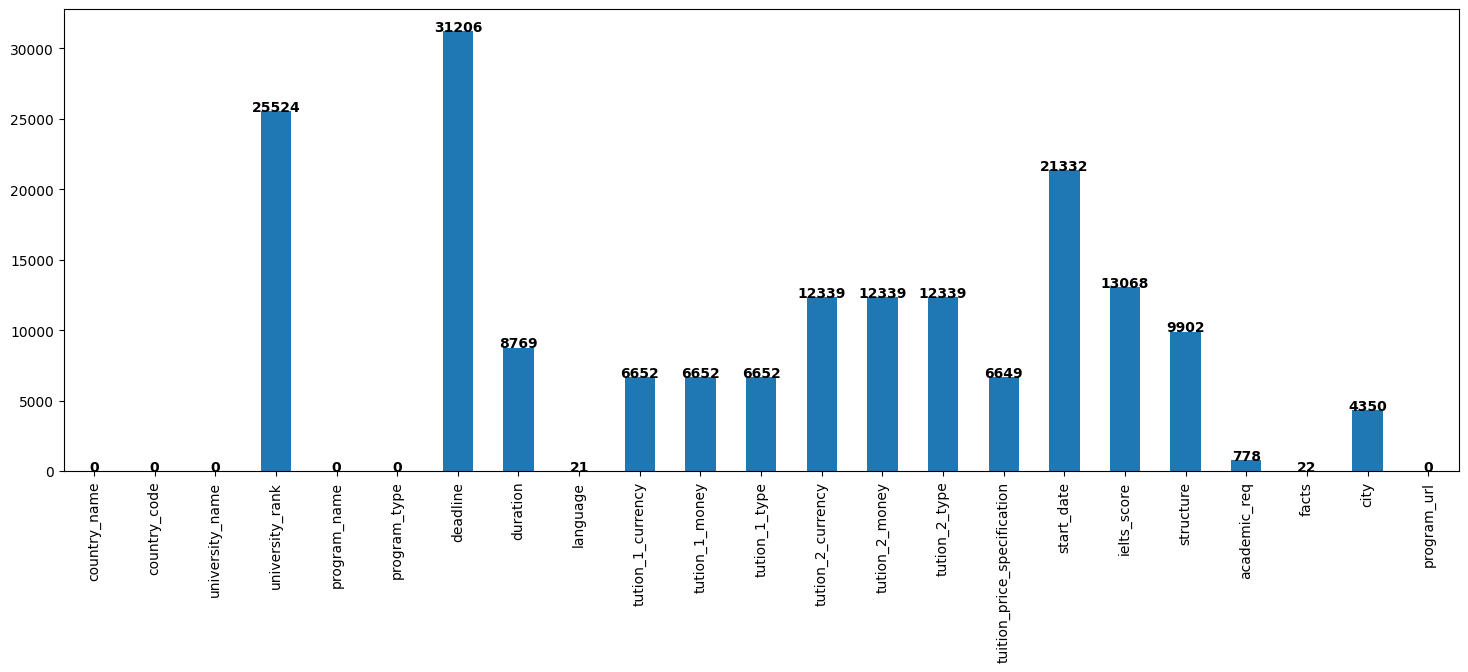

In [6]:
missing_values = df.isnull().sum()
fig, ax = plt.subplots(figsize=(18, 6))
missing_values.plot.bar(ax=ax)

for i, val in enumerate(missing_values):
    ax.text(i, val + 10, str(val), ha='center', fontweight='bold')
    
plt.show()


# **Preprocessing Dataset**

**delete useless records**

In [7]:
# delete rows with the most percentage of null values (21 rows)

df["empty_count"] = df.isnull().sum(axis=1)
max_emptiness = df["empty_count"].max()
#useless_rows_count = (df["empty_count"] == max_emptiness).sum()
df = df[~(df["empty_count"] == max_emptiness)]

**delete useless columns**


In [8]:
# delete country_code and program_url columns

del df["country_code"]
del df["program_url"]

**handle missing data**

"duration"

In [9]:
def convert_months_to_days(duration):
    if pd.isna(duration):
        return np.nan
    elif 'months' or 'month' in duration:
        months = int(duration.split()[0])
        days = months * 30
        return days
    elif 'days' or 'day' in duration:
        return int(duration.split()[0]);
    else:
        return int(duration)

df['duration'] = df['duration'].apply(convert_months_to_days)
median_duration = df["duration"].median()
df["duration"].fillna(median_duration, inplace=True)

"tution"

In [10]:
least_tution = df["tution_1_money"].min()

df['tution_1_money'].fillna(df['tution_2_money'], inplace=True)
df['tution_2_money'].fillna(df['tution_1_money'], inplace=True)

df['tution_1_money'].fillna(least_tution, inplace=True)
df['tution_2_money'].fillna(least_tution, inplace=True)

"tution price specification"

In [11]:
df['tuition_price_specification'].fillna(method='ffill', inplace=True)

"normalizing tuition"

In [12]:
def normalize_tution(data, func_type):
    tution_type = data["tuition_price_specification"]
    duration = data['duration']
    tuition = data['tution_1_money'] if func_type == 1 else data['tution_2_money']
    result = 0

    if tution_type == "Tuition (Credit)":
        result = tuition * 30

    elif tution_type == "Tuition (Module)":
        result = tuition * 10

    elif tution_type == "Tuition (Quarter)":
        result = tuition * 2

    elif tution_type == "Tuition (Month)":
        result = tuition * 6

    elif tution_type == "Tuition (Year)":
        result = tuition / 2
        
    elif tution_type == "Tuition (Trimester)":
        result = tuition / 3

    elif tution_type == "Tuition (Full programme)":
        if duration < 180:
            sems = 1
        else:
            sems = duration / 180
            result = tuition / sems
    
    else:
        result = tuition

    return result


df["tution_1_money"] = df.apply(normalize_tution, func_type=1, axis=1)

df["tution_2_money"] = df.apply(normalize_tution, func_type=2, axis=1)

In [13]:
# all tutions are now based on semester
df["tuition_price_specification"] = "Tuition (Semester)"    

average_tution = df["tution_1_money"].mean()
df["affordability"] = df["tution_1_money"].apply(lambda x: "affordable" if x <= average_tution else "expensive")

In [14]:
# turn duration to normal format(day to month)
def convert_days_to_month(duration):
    result = ""
    if duration < 30:
        result = str(duration) + " days"
    else:
        result = str(duration / 30) + " months"
    return result

df['duration'] = df['duration'].apply(convert_days_to_month)


"tution 1 and 2 type"

In [15]:
df['tution_1_type'].fillna(method='ffill', inplace=True)
df['tution_2_type'].fillna(method='ffill', inplace=True)

"tution 1 and 2 currency"

In [16]:
df['tution_1_currency'].fillna(method='ffill', inplace=True)
df['tution_2_currency'].fillna(method='ffill', inplace=True)

"ielts score"

In [17]:
least_score = df["ielts_score"].min()

df["ielts_score"].fillna(least_score, inplace=True)

"deadline"

In [18]:
df['deadline'].fillna(method='ffill', inplace=True)

desired_date = '2022-09-13'
df["availability"] = df["deadline"].apply(lambda x: "available" if x > desired_date else "unavailable")

"start date"

In [19]:
df['start_date'].fillna(method='ffill', inplace=True)

"structure"

In [20]:
def clean_courses(structure):
    courses = []
    if pd.notna(structure):        
        structure = structure.strip("['']")     # remove [' ']
        regex = r'\(.*?\)'    
        
        for course in structure.split(','):
            course = course.strip()
            course = re.sub(regex, '', course)  # remove ( )
            course = re.sub(r"'", '', course)   # remove single quotations
            
            if 'credit' in course:              # remove credit
                course = course[:course.index('credit')].strip()
            courses.append(course)
        return ', '.join(courses)

    else:
        return "the courselist for this program is not defined."


df['structure'] = df['structure'].apply(clean_courses)

"rank"

In [21]:
max_rank = df['university_rank'].max() + 1

def fill_missing_ranks(group):
    global max_rank
    if group['university_rank'].isna().all():
        group['university_rank'].fillna(max_rank, inplace=True)
        max_rank += 1
    else:
        group['university_rank'].fillna(method='ffill', inplace=True)
        group['university_rank'].fillna(method='bfill', inplace=True)
    
    return group

df = df.groupby('university_name', group_keys=False).apply(fill_missing_ranks)

"city"

In [22]:
# remove [' '] from city name

df['city'] = df['city'].str.strip("['']")

In [23]:
! pip install countryinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 602.2/602.2 kB 13.3 MB/s eta 0:00:00


In [24]:
# fill null cities with countryInfo library 

from countryinfo import CountryInfo

def fill_cities(data):
    country = data['country_name'].lower()

    if ',' in country:
        head, sep, tail = country.partition(',')
        country = head

    city = data['city']

    if pd.isna(city):
        if country == 'macedonia':
            city = 'Skopje'
        elif country == 'palestinian territory':
            city = 'Ramallah'
        elif country == 'korea':
            city = 'Seoul'
        elif country == 'viet nam':
            city = 'Hanoi'
        else:
            city = CountryInfo(country).capital()

    return city

df['city'] = df.apply(fill_cities, axis=1)

"academic requirements"

In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [26]:
def extract_main_req(content):
  soup = BeautifulSoup(content, 'html.parser')
  main_req = ""
  for li in soup.find_all('li'):
    main_req += li.text

  return main_req


df['main_req'] = df.apply(lambda x: (extract_main_req(x['academic_req']) if pd.notna(x['academic_req']) else ''), axis=1)


In [27]:
def clean_main_req(content):
  text_wo_details = re.sub("[\(\[].*?[\)\]]", "", content.lower())
  text_wo_puncs = text_wo_details.translate(str.maketrans('','',string.punctuation))

  return text_wo_puncs

df['main_req'] = df.apply(lambda x: (clean_main_req(x['main_req']) if pd.notna(x['main_req']) else ''), axis=1)


In [28]:
def keyword_extraction(content):
  sentences = []

  doc = nlp(content)

  for sent in doc.sents:
    selected_words = []
    for token in sent:
      if token.pos_ in candidate_pos and token.is_stop is False:
        selected_words.append(token)

    sentences.append(selected_words)

  return sentences


nlp = spacy.load('en_core_web_sm')
stopWords = set(stopwords.words('english'))
candidate_pos = ['NOUN', 'PROPN', 'VERB']


df['req_keywords'] = df.apply(lambda x: (keyword_extraction(x['main_req']) if pd.notna(x['main_req']) else ''), axis=1)


**duplication detection**

In [29]:
# no duplication found

duplicate_rows = df.duplicated()
df.drop_duplicates()


TypeError: ignored

In [ ]:
df.shape

(60404, 25)

# **Collect Keywords**

In [30]:
def extract_keywords(row):
    keywords = []
    keywords.append(f"rank {row['university_rank']}")
    keywords.append(f"loacted in {row['country_name']}, {row['city']}")
    keywords.append(f"{row['duration']} program")
    keywords.append(f"tuition is {row['tution_1_money']}")
    keywords.append(row['affordability'])
    keywords.append(f"starts from {row['start_date']}")
    keywords.append(row['availability'])
    keywords.append(f"minimum IELTS score {row['ielts_score']}")
    keywords.append(f"course list: {row['structure']}")
    keywords.append(f"additional info: {row['req_keywords']}")

    return ', '.join(keywords)

df['extracted_keywords'] = df.apply(extract_keywords, axis=1)


In [42]:
print(df.head())

  country_name                 university_name  university_rank  \
0      Armenia  American University of Armenia            843.0   
1      Armenia  American University of Armenia            843.0   
2      Armenia  American University of Armenia            843.0   
3      Armenia  American University of Armenia            843.0   
4      Armenia  American University of Armenia            843.0   

                                    program_name program_type  \
0                                      Economics          MSc   
1    Political Science and International Affairs       Master   
2                        Business Administration          MBA   
3               Computer and Information Science          MSc   
4  Industrial Engineering and Systems Management         MEng   

               deadline     duration language tution_1_currency  \
0  2004-07-18T00:00:00Z  24.0 months  English               EUR   
1  2031-07-18T00:00:00Z  24.0 months  English               EUR   
2  20

# **Word Cloud**

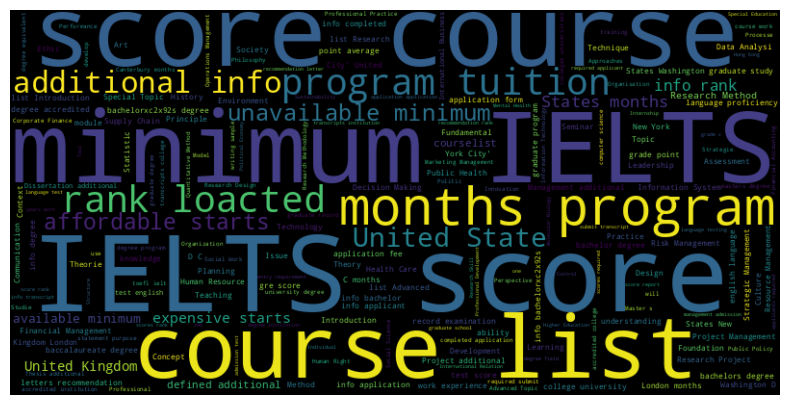

In [31]:
text_data = ' '.join(df['extracted_keywords'])  

wordcloud = WordCloud(width=800, height=400).generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# **Get Input from User**

In [ ]:
pd.options.display.max_colwidth = None

university_name = input("plaese enter the name of the university: ")
field_name = input("please enter the name of the field: ")
output = ""

result = df[(df["university_name"] == university_name) & (df["program_name"] == field_name)]

if result.empty:
    print("sorry! there's no matching result!")
else:
    print("\nhere's some information about this university and field: ")
    output = result["extracted_keywords"].to_string(index=False)
    print(output)  

#write output to a file
with open('sample_data/keywords.txt', 'w') as f:
    f.write(output) 
